In [95]:
import pandas as pd
import numpy as np
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt

import sys, os

# pega o diretório pai (projeto) e adiciona ao path
import sys, os
proj_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)


import importlib
import funcs.aux_utils
importlib.reload(funcs.aux_utils)
from funcs.aux_utils import ChartMaker

import os

from warnings import filterwarnings

filterwarnings('ignore')

TRAIN_DIR = '../data/parquet_files/train/'
TEST_DIR = '../data/parquet_files/test/'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)


# Sobre os dados

Em decorrência da quantidade de tabelas e de colunas, será necessário a construção de um Pipeline e de uma classe auxiliar para lidar com esta quantidade massiva de dados.

O primeiro ponto da análise dos dados é verificar a distribuição da variável alvo e quantidade de missings das tabelas de treino(target). 

Por isso, primeiro verificarei a distribuição do target. Após isso realizar a separação do conjunto de validação e de teste estratificado com base na distribuição do variável alvo.

In [96]:
data = pl.read_parquet(f'{TRAIN_DIR}/train_base.parquet')


print(data.n_unique())
data.head()

1526659


case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1


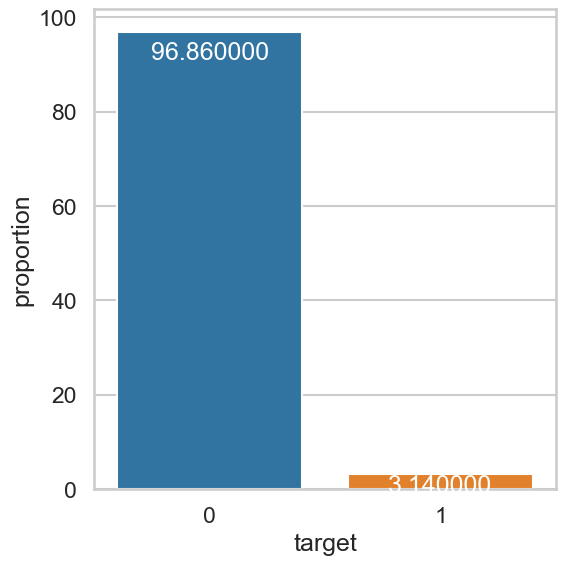

Proporção do target
Clientes não inadimplentes (em %): 3.14
Clientes não inadimplentes (em %): 96.86


In [97]:
chart_maker = ChartMaker(figure_size=(6, 6))

count_target = data['target'].value_counts(normalize=True)
count_target = count_target.with_columns([
    (pl.col('proportion') * 100).round(2).alias('proportion')
])

chart_maker.plot_bar_chart(X=count_target['target'], y=count_target['proportion'])

print('Proporção do target')
print(f'Clientes não inadimplentes (em %): {count_target['proportion'][0]}')
print(f'Clientes não inadimplentes (em %): {count_target['proportion'][1]}')

del chart_maker

Podemos ver que a classe alvo é bastante desbalanceada, tendo cerca de apenas 3,1% dos clientes inadimplementes. Denota-se então a necessidade da aplicação e cuidado de técnicas de modo a não enviesar o modelo e causar um overfit a respeito do conjunto de treinamento. Dessa forma, para garantir que o processo de EDA e de criação do modelo esteja seguro de vazamento de dados, separaremos o conjunto de dados em: 

    1. Treino
    2. Validação
    3. Teste

Utilizaremos a função train_test_split do scikit-learn com o parâmetro "stratify" aplicado em virtude do desbalanceamento do target.

In [103]:
from sklearn.model_selection import train_test_split

X = data.drop('target')
y = data['target']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.25, random_state=42)

print(f'Shape do conjunto de variáveis preditoras de treinamento: {X_train.shape} | proporção: {X_train.shape[0] / data.shape[0] * 100:.2f}')
print(f'Shape do conjunto de variáveis preditoras de validação: {X_val.shape} | proporção: {X_val.shape[0] / data.shape[0] * 100:.2f} ')
print(f'Shape do conjunto de variáveis preditoras de teste: {X_test.shape} | proporção: {X_test.shape[0] / data.shape[0] * 100:.2f} ')
print(f'Shape da variável alvo de treinamento: {y_train.shape} | proporção: {y_train.shape[0] / data.shape[0] * 100:.2f} ')
print(f'Shape da variável alvo de validação: {y_val.shape} | proporção: {y_val.shape[0] / data.shape[0] * 100:.2f} ')
print(f'Shape da variável alvo de test: {y_test.shape} | proporção: {y_test.shape[0] / data.shape[0] * 100:.2f} ')

train = X_train.with_columns(y_train)
val = X_val.with_columns(y_val)
test = X_test.with_columns(y_test)

Shape do conjunto de variáveis preditoras de treinamento: (915995, 4) | proporção: 60.00
Shape do conjunto de variáveis preditoras de validação: (305332, 4) | proporção: 20.00 
Shape do conjunto de variáveis preditoras de teste: (305332, 4) | proporção: 20.00 
Shape da variável alvo de treinamento: (915995,) | proporção: 60.00 
Shape da variável alvo de validação: (305332,) | proporção: 20.00 
Shape da variável alvo de test: (305332,) | proporção: 20.00 


case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
827467,"""2019-10-11""",201910,40,0
1540584,"""2019-09-16""",201909,36,0
1728905,"""2020-01-02""",202001,52,0
16534,"""2019-05-28""",201905,21,0
749013,"""2019-07-22""",201907,28,0


Separados em seus respectivos conjuntos, vamos avaliar quantos valores missing o conjunto de treino possui.

In [ ]:
missings = train.null_count()

missings

case_id,date_decision,MONTH,WEEK_NUM,target
u32,u32,u32,u32,u32
0,0,0,0,0


Mesmo que o dataset não possua valores faltantes, é crucial que durante a fase de pré-procesamento algum tipo de estratégia de imputing seja realizada, dessa forma, ao fazer a Pipeline de pré-processamento, incluiremos funções responsáveis por lidar com tais valores.

A seguida, vamos definir como trataremos as demais tabelas do dataset. Portanto, para que o processo de leitura e EDA da tabela seja bem sucedido e de maneira eficaz, iremos aplicar algumas transformações nos dados. Para isso, seguiremos algumas premissas:

- Tabelas com depth > 1 (que representam medidas retiradas dos dados estáticos) serão agregadas (utilizando "case_id") a partir de alguns critérios, são eles:

    - Disclaimer: As colunas das tabelas com profundidade possuem identificadores em seus nomes, indicando qual tipo de transformações foram aplicadas nestas tabelas, são elas:
        1. **P** (Days over due - Dias em atraso): Medidas que envolvem datas de atrasos, proporções de datas e etc.
        2. **M** (Masking categorias - Categorias com máscaras): Categorias como genêro, status e outros dados categóricos
        3. **A** (Tranform Ammount - Transformações de quantidade): Quantidades numéricas que foram transformadas ou processadas seguindo alguma lógica
        4. **D** (Transform Date - Transformações de datas): Colunas que dizem a respeito sobre datas que foram adicionadas como informações relevantes 
        5. **T** e **L** (Unespecified Transform - Transformações não inespecificadas): Valores que não se encaixam em nenhuma das outras categorias e não possuem "tracking" de informações, entretanto, podem sinalizar informações relevantes ao modelo.

    - **Para colunas terminadas em P e A (dados numéricos)**: Será aplicado um casting de tipo e agregações por -> Valor máximo, último valor e média
    - **Para colunas terminadas em D**: Será aplicado casting para date e agregações por -> Valor máximo, última data e média
    - **Para colunas terminadas em M (Strings)**: Será aplicado um casting para "category" e posteriormente agregadas por -> Valor máximo (lexicograficamente o último) e o último valor
    - **Para outras colunas**: Definiremos agregações por -> Máximo e último valor 

Portanto para estes processos ocorrerem de forma harmoniosa e automatizada utilizaremos as classes definidas no pacote funcs.aux_utils.py com o intuito de aplicar tais transformações e ao final juntar todas as tabelas baseado no "case_id".